## ch09 XGBoost
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.25</div>
<div style="text-align: right"> Last update: 2023.7.25</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

#### 9.4 Creating XGBoost Model

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

#### 9.5 A Boosted Model

In [9]:
xg_oob = xgb.XGBClassifier()
xg_oob.fit(X_train, y_train)
xg_oob.score(X_test, y_test)

0.7458563535911602

In [10]:
xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)
xg2.fit(X_train, y_train)
xg2.score(X_test, y_test)

0.6685082872928176

- 성능이 더 떨어졌다.  

첫번째 트리(tree_index = 0)를 살펴보자.  



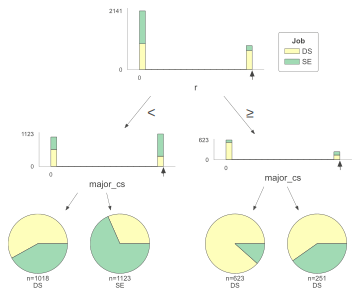

In [11]:
import dtreeviz

viz = dtreeviz.model(xg2, X_train = X, y_train =y, target_name='Job',
                     feature_names=list(X_train.columns),
                     class_names=['DS', 'SE'],
                     tree_index=0
                     )
viz.view(depth_range_to_display=[0, 2])

### 9.6 Understanding the Output of the Trees

In [12]:
xhelp.my_dot_export(xg2, num_trees=0, filename='xgb_md2.dot',
title='First Tree')


(process:77351): Pango-WARNING **: 09:11:37.232: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


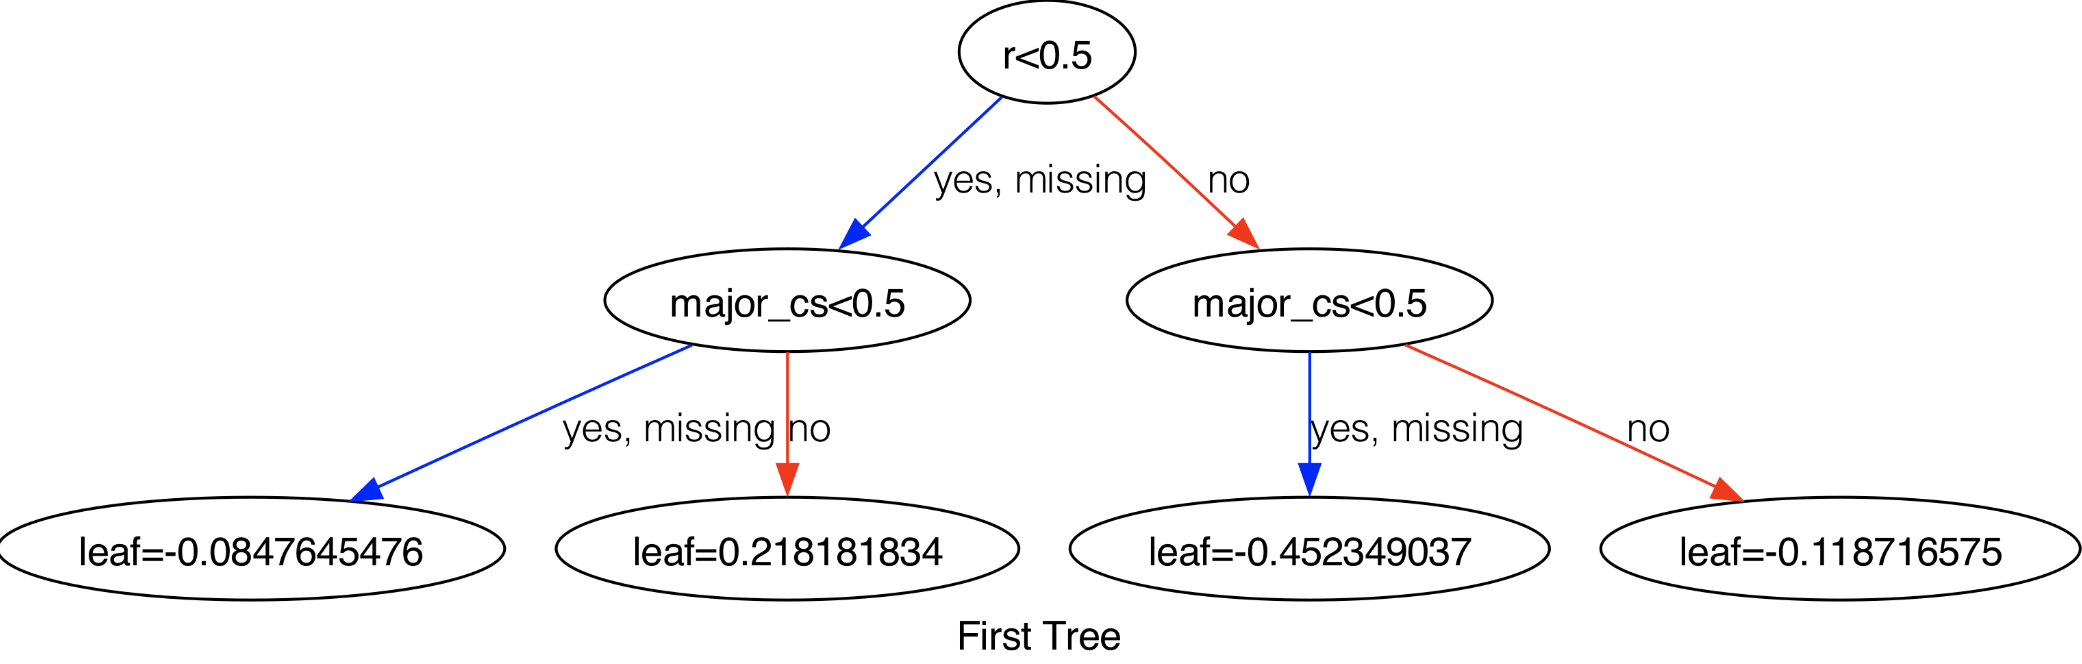

모델이 예측하는 방식을 살펴보자.   

 It predicts 49.8% data scientist and 50.1%
software engineer. 

Because 50.1% is greater than 50%, our model predicts 1 or software
engineer for this example.


In [13]:
# Predicts 1 - Software engineer
se7894 = pd.DataFrame({'age': {7894: 22},                                            
                       'education': {7894: 16.0},
                       'years_exp': {7894: 1.0},
                       'compensation': {7894: 0}, 
                       'python': {7894: 1},
                       'r': {7894: 0},
                       'sql': {7894: 0},
                       'Q1_Male': {7894: 1},                                   
                       'Q1_Female': {7894: 0},
                       'Q1_Prefer not to say': {7894: 0},
                       'Q1_Prefer to self-describe': {7894: 0},
                       'Q3_United States of America': {7894: 0},
                       'Q3_India': {7894: 1},
                       'Q3_China': {7894: 0},
                       'major_cs': {7894: 0},
                       'major_other': {7894: 0},
                       'major_eng': {7894: 0},
                       'major_stat': {7894: 0}})

In [14]:
xg2.predict_proba(se7894)

array([[0.4986236, 0.5013764]], dtype=float32)

In [15]:
xg2.predict(pd.DataFrame(se7894))

array([1])

이제 두번째 트리에서 발생하는 상황을 살펴보자.(num_trees = 1)

In [16]:
xhelp.my_dot_export(xg2, num_trees=1, filename='xgb_md2_tree1.dot', title='Second Tree')


(process:77353): Pango-WARNING **: 09:11:37.553: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


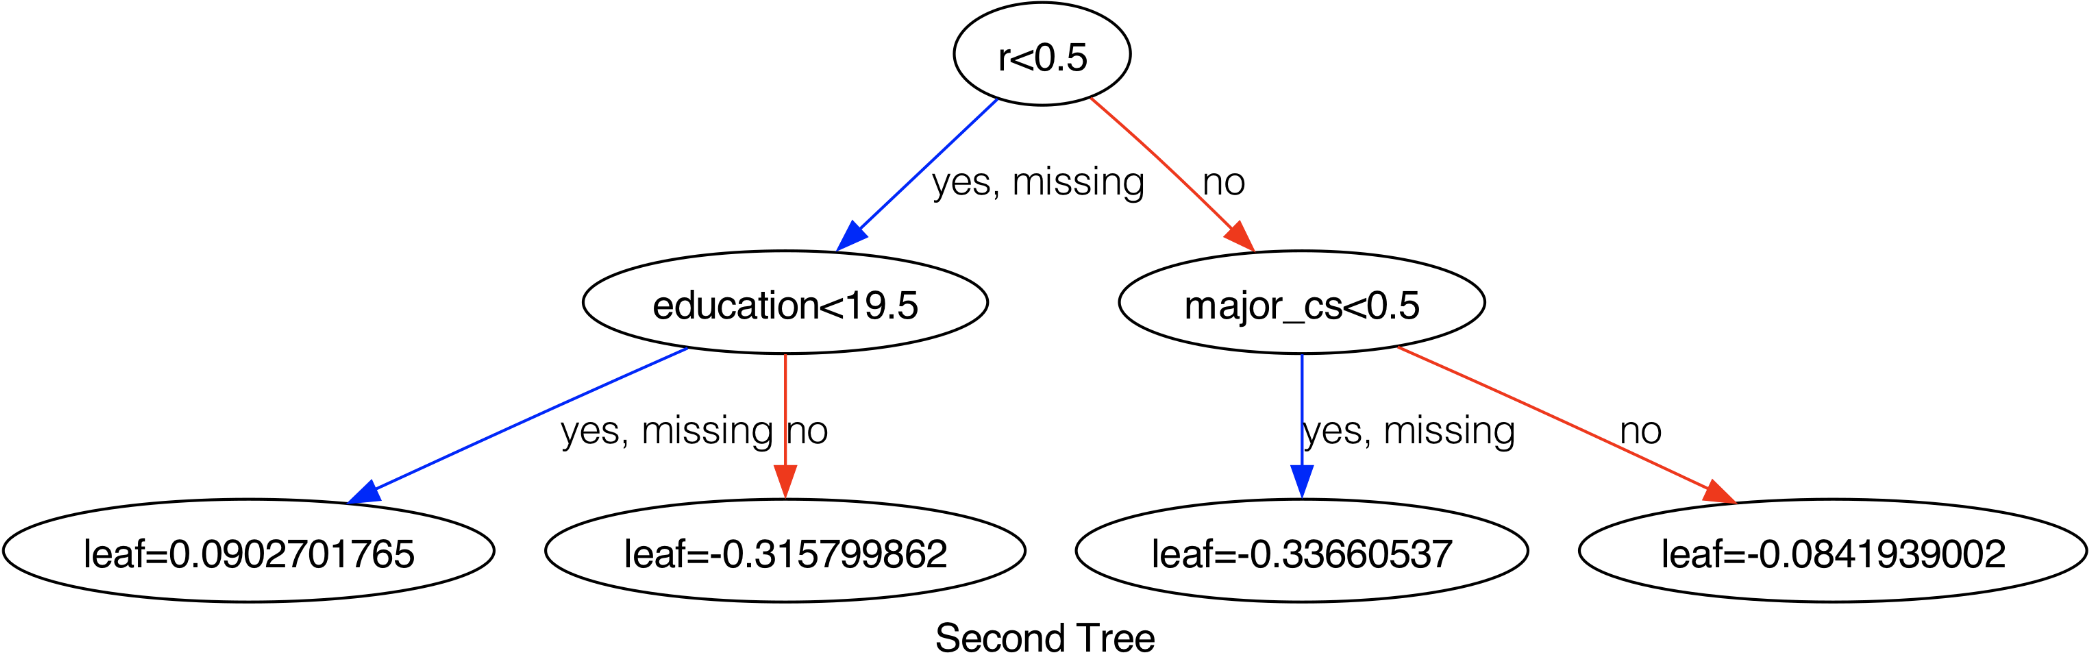

- 첫번째 노드에서 왼쪽으로 가고, 교육 레벨이 16이므로 또 왼쪽으로 간다.  
- 최종적으로 리프의 값이 0.0902이다.  
- 예측 결과는 리프 값에 inverse logit sum을 구하는 것이다. 이 값은 positive 클래스읜 확률이다.

In [17]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [18]:
inv_logit(-0.08476+0.0902701)

0.5013775215147345

- 50.1% 확률로 소프트웨어 엔지니어라는 의미이다.